# Sheet 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
%matplotlib inline

In [1]:
print("AAAAAaaaaaaaaa")

AAAAAaaaaaaaaaaaa


## 1 Principal Component Analysis
### (a)

In [ ]:
# TODO: implement PCA (fill in the blanks in the function below)

def pca(data, n_components=None):
    """
    Principal Component Analysis on a p x N data matrix.
    
    Parameters
    ----------
    data : np.ndarray
        Data matrix of shape (p, N).
    n_components : int, optional
        Number of requested components. By default returns all components.
        
    Returns
    -------
    np.ndarray, np.ndarray
        the pca components (shape (n_components, p)) and the projection (shape (n_components, N))

    """
        # set n_components to p by default
    n_components = data.shape[0] if n_components is None else n_components
    assert n_components <= data.shape[0], f"Got n_components larger than dimensionality of data!"
    
    N = data.shape[1]
    # center the data
    x = np.matmul(data,np.identity(N)-np.ones((N,N))/N)
    # compute X times X transpose
    xx = np.matmul(x,x.T)
    # compute the eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eig(xx)
    # sort the eigenvectors by eigenvalue and take the n_components largest ones
    ind = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[ind]
    eigenvectors = eigenvectors[ind]
    W = eigenvectors[:n_components]
    # compute X_projected, the projection of the data to the components
    X_projected = np.matmul(W,x)
    
    return W, X_projected  # return the n_components first components and the pca projection of the data


In [3]:
# Example data to test your implementation 
# All the asserts on the bottom should go through if your implementation is correct

data = np.array([
    [ 1,  0,  0, -1,  0,  0],
    [ 0,  3,  0,  0, -3,  0],
    [ 0,  0,  5,  0,  0, -5]
], dtype=np.float32)

# add a random offset to all samples. it should not affect the results
data += np.random.randn(data.shape[0], 1)

n_components = 2
components, projection = pca(data, n_components=n_components)  # apply your implementation

# the correct results are known (up to some signs)
true_components = np.array([[0, 0, 1], [0, 1, 0]], dtype=np.float32)
true_projection = np.array([
    [ 0,  0,  5,  0,  0, -5],
    [ 0,  3,  0,  0, -3,  0]
], dtype=np.float32)

# check that components match, up to sign
assert isinstance(components, np.ndarray), f'Expected components to be numpy array but got {type(components)}'
assert components.shape == true_components.shape, f'{components.shape}!={true_components.shape}'
assert np.allclose(np.abs(components * true_components).sum(1), np.ones(n_components)), f'Components not matching'

# check that projections agree, taking into account potentially flipped components
assert isinstance(projection, np.ndarray), f'Expected projection to be numpy array but got {type(projection)}'
assert projection.shape == (n_components, data.shape[1]), f'Incorrect shape of projection: Expected {(n_components, data.shape[1])}, got {projection.shape}'
assert np.allclose(projection, true_projection * (components * true_components).sum(1, keepdims=True), atol=1e-6), f'Projections not matching'

print('Test successful!')

Test successful!


### (b)

Load the data (it is a subset of the data at https://opendata.cern.ch/record/4910#)

In [3]:
features = np.load('data/dijet_features.npy')
labels = np.load('data/dijet_labels.npy')
label_names = ['b', 'c', 'q']  # bottom, charm or light quarks
label_index , counts = np.unique(labels,return_counts=True)
for i in range(3):
    print(f"{label_names[i]} samples: {counts[i]}")
print(f'{features.shape=}, {labels.shape=}')  # print the shapes

# TODO: print how many samples of each class are present in the data (hint: numpy.unique)·

b samples: 999
c samples: 864
q samples: 370
features.shape=(116, 2233), labels.shape=(2233,)


Text(0.5, 1.0, 'Range of the features')

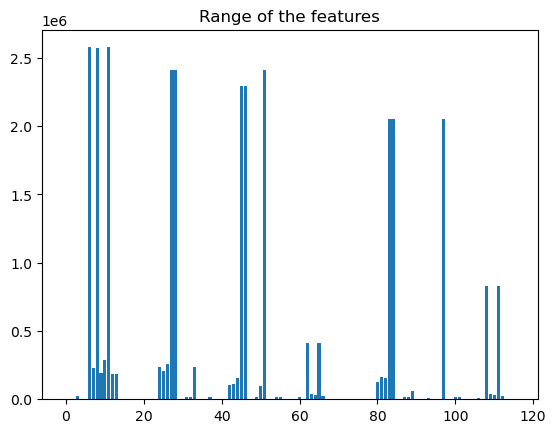

In [18]:
range_f = np.zeros((features.shape[0]))
norm_f = np.zeros(features.shape)
for i in range(features.shape[0]):
    range_f[i] = np.max(features[i,:]) - np.min(features[i,:]) 
    norm_f[i,:] = (features[i,:] - np.mean(features[i,:]))/np.std(features[i,:])
    
plt.bar(range(0,features.shape[0]),range_f)
plt.title("Range of the features")

Normalize the data

In [5]:
# TODO: report range of features and normalize the data to zero mean and unit variance
range_f = np.column_stack((np.min(features, axis=1), np.max(features, axis=1)))

# Normalize each row
norm_f = (features - np.mean(features, axis=1, keepdims=True)) / np.std(features, axis=1, keepdims=True)

### (c)
Compute a 2D PCA projection and make a scatterplot of the result, once without color, once coloring the dots by label. Interpret your results.

In [21]:
# TODO: apply PCA as implemented in (a)
dijet_components, dijet_projection = pca(norm_f, n_components=2)

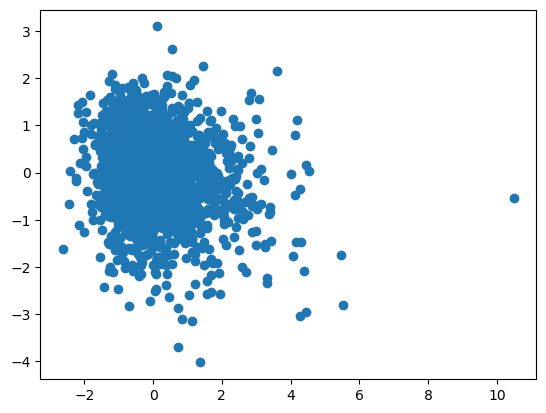

In [22]:
# TODO: make a scatterplot of the PCA projection
fig, ax = plt.subplots()
ax.scatter(dijet_projection[0],dijet_projection[1])

[0. 1. 2.]


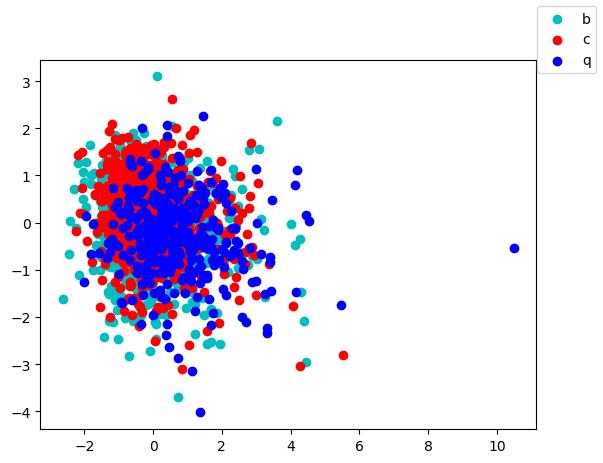

In [23]:
# TODO: make a scatterplot, coloring the dots by their label and including a legend with the label names
# (hint: one way is to call plt.scatter once for each of the three possible labels. Why could it be problematic to scatter the data sorted by labels though?)
fig, ax = plt.subplots()
print(np.unique(labels))
colours = ['c','r','b']
for i in range(3):
        ind = np.where(labels == i)
        ax.scatter(dijet_projection[0][ind],dijet_projection[1][ind],c = colours[i], label = label_names[i])

fig.legend()
# TODO: make a scatterplot of the PCA projection
#fig, ax = plt.subplots()
#ax.scatter(dijet_projection[0],dijet_projection[1])


The classes are not seppareted properly in this distribution, we would have either use more features or go to non linear pca. 

## 2 Nonlinear Dimension Reduction

In [1]:
import umap  # import umap-learn, see https://umap-learn.readthedocs.io/

In [ ]:
# if you have not done 1(b) yet, you can load the normalized features directly:
features = np.load('data/dijet_features_normalized.npy')
labels = np.load('data/dijet_labels.npy')
label_names = ['b', 'c', 'q']  # bottom, charm or light quarks

### (a)

In [6]:
# TODO: Apply umap on the normalized jet features from excercise 1. It will take a couple of seconds.
# note: umap uses a different convention regarding the feature- and sample dimension, N x p instead of p x N!

reducer = umap.UMAP()
reduced = reducer.fit_transform(norm_f.T)

[0. 1. 2.]


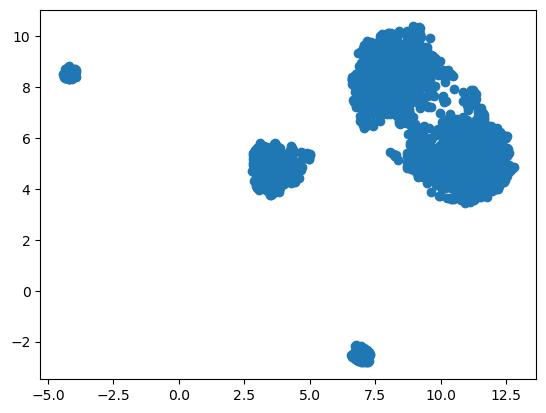

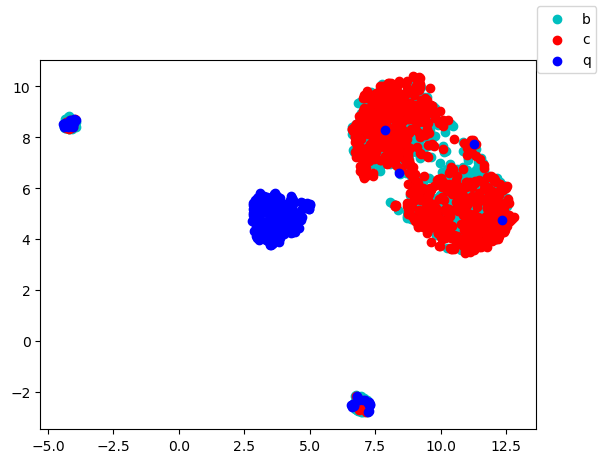

In [11]:
# TODO: make a scatterplot of the UMAP projection
fig, ax = plt.subplots()
ax.scatter(reduced[:,0],reduced[:,1])
# TODO: make a scatterplot, coloring the dots by their label and including a legend with the label names

fig, ax = plt.subplots()
colours = ['c','r','b']
for i in range(3):
        ind = np.where(labels == i)
        ax.scatter(reduced[ind,0],reduced[ind,1],c = colours[i], label = label_names[i])

fig.legend()

### (b)

c:\Users\Javier\miniconda3\envs\mlph_1\lib\site-packages\sklearn\manifold\_spectral_embedding.py:455: UserWarning: Exited at iteration 1732 with accuracies 
[9.54476854e-15 8.71606438e-06 1.74936031e-06 4.41589737e-06]
not reaching the requested tolerance 4.664063453674316e-06.
Use iteration 1732 instead with accuracy 
3.7203305188467743e-06.

  _, diffusion_map = lobpcg(
c:\Users\Javier\miniconda3\envs\mlph_1\lib\site-packages\sklearn\manifold\_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[2.28023421e-15 8.71606443e-06 1.74935947e-06 4.41589761e-06]
not reaching the requested tolerance 4.664063453674316e-06.
  _, diffusion_map = lobpcg(
c:\Users\Javier\miniconda3\envs\mlph_1\lib\site-packages\umap\spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
c:\Users\Javier\minic

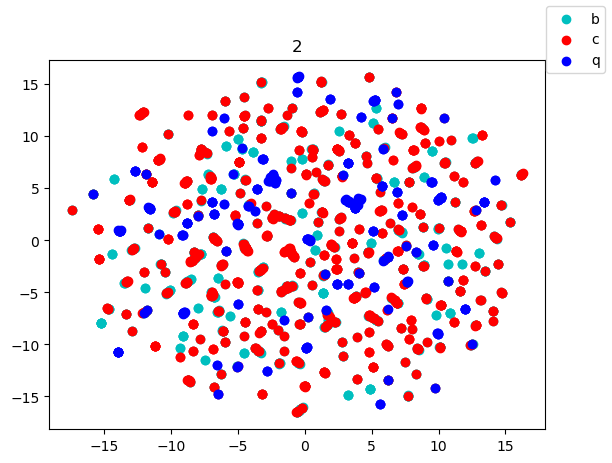

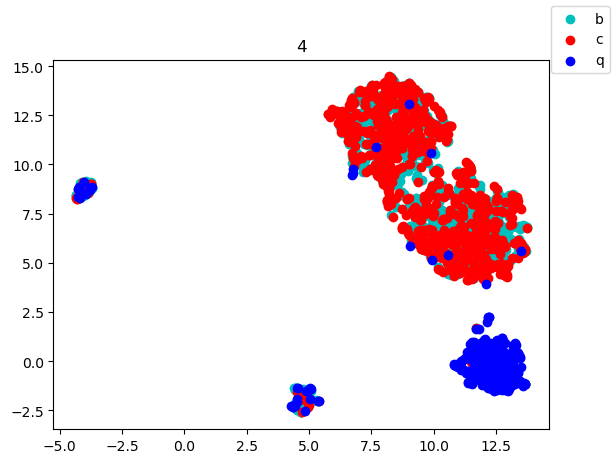

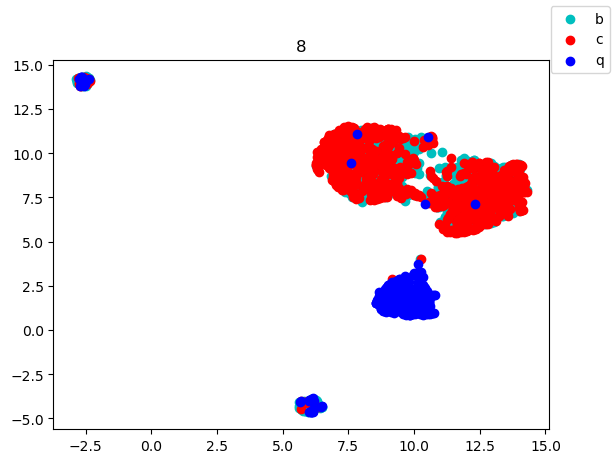

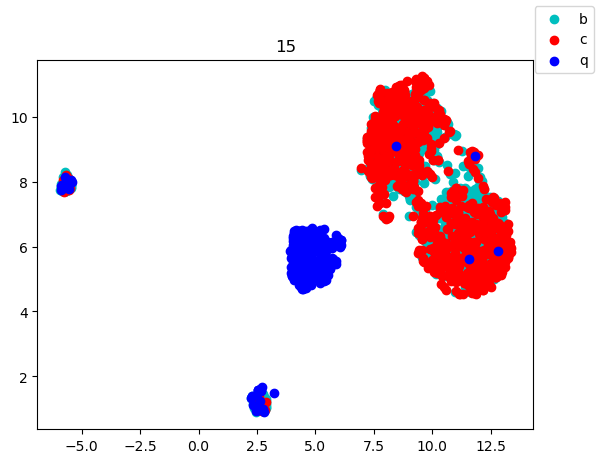

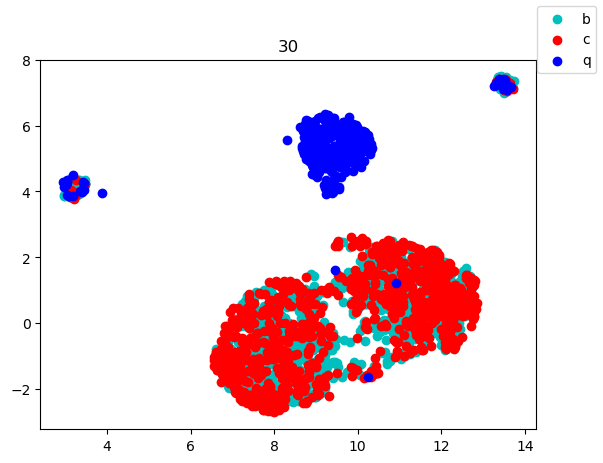

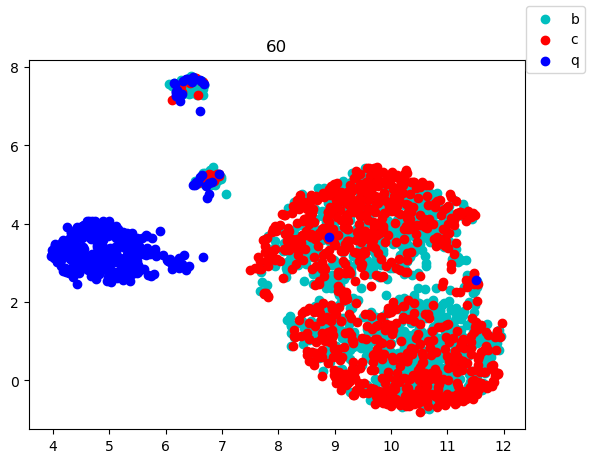

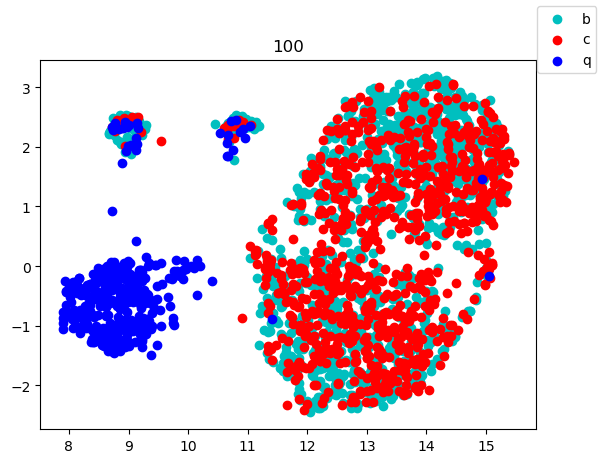

In [14]:
colours = ['c','r','b']

for n_neighbors in (2, 4, 8, 15, 30, 60, 100):
        # TODO: repeat the above, varying the n_neighbors parameter of UMAP
        reducer = umap.UMAP(n_neighbors=n_neighbors)
        reduced = reducer.fit_transform(norm_f.T)
        fig, ax = plt.subplots()
        for i in range(3):
                ind = np.where(labels == i)
                ax.scatter(reduced[ind,0],reduced[ind,1],c = colours[i], label = label_names[i])
        fig.legend()
        ax.set_title(n_neighbors)

We can observe that from 8 neighbours onwards the distributions stay more or less similar